In [57]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}<style>"))

# Deeplab-V3

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
from keras.models import Model
from keras import layers
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Add
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import DepthwiseConv2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import Lambda
from keras.engine import Layer
from keras.engine import InputSpec
from keras.engine.topology import get_source_inputs
from keras.optimizers import Adam
from keras import backend as K
from keras.applications import imagenet_utils
from keras.utils import conv_utils, multi_gpu_model
from keras.utils.data_utils import get_file
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DATA_SHAPE = 224

Using TensorFlow backend.


In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('seg.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_acc', patience=5, mode='max')
callback_list = [checkpoint, earlystop]

# Load data

In [2]:
%%time
import numpy as np
train_images = np.load('/home/mc16/pre_data/train_image_%s.npy'%DATA_SHAPE)
val_images = np.load('/home/mc16/pre_data//val_image_%s.npy'%DATA_SHAPE)
train_labels = np.load('/home/mc16/pre_data/train_label_%s.npy'%DATA_SHAPE)
val_labels = np.load('/home/mc16/pre_data//val_label_%s.npy'%DATA_SHAPE)

CPU times: user 4.51 ms, sys: 1.85 s, total: 1.85 s
Wall time: 1.85 s


In [2]:
class BilinearUpsampling(Layer):
    """Just a simple bilinear upsampling layer. Works only with TF.
       Args:
           upsampling: tuple of 2 numbers > 0. The upsampling ratio for h and w
           output_size: used instead of upsampling arg if passed!
    """

    def __init__(self, upsampling=(2, 2), output_size=None, data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)

        self.data_format = conv_utils.normalize_data_format(data_format)
        self.input_spec = InputSpec(ndim=4)
        if output_size:
            self.output_size = conv_utils.normalize_tuple(
                output_size, 2, 'output_size')
            self.upsampling = None
        else:
            self.output_size = None
            self.upsampling = conv_utils.normalize_tuple(
                upsampling, 2, 'upsampling')

    def compute_output_shape(self, input_shape):
        if self.upsampling:
            height = self.upsampling[0] * \
                input_shape[1] if input_shape[1] is not None else None
            width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        else:
            height = self.output_size[0]
            width = self.output_size[1]
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        if self.upsampling:
            return K.tf.image.resize_bilinear(inputs, (inputs.shape[1] * self.upsampling[0],
                                                       inputs.shape[2] * self.upsampling[1]),
                                              align_corners=True)
        else:
            return K.tf.image.resize_bilinear(inputs, (self.output_size[0],
                                                       self.output_size[1]),
                                              align_corners=True)

    def get_config(self):
        config = {'upsampling': self.upsampling,
                  'output_size': self.output_size,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x

In [4]:
def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)

In [5]:
def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs
    
def relu6(x):
    return K.relu(x, max_value=6)

In [6]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x

In [9]:
def Deeplabv3(input_tensor=None, backbone='mobilenetv2', OS=16, alpha=1., input_shape=(224, 224, 3)):
    """ Instantiates the Deeplabv3+ architecture

    This model is available for TensorFlow only,
    and can only be used with inputs following the TensorFlow
    data format `(width, height, channels)`.
    # Arguments
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone

    # Returns
        A Keras model instance.

    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`

    """

    if K.backend() != 'tensorflow':
        raise RuntimeError('The Deeplabv3+ model is only available with '
                           'the TensorFlow backend.')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation('relu')(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation('relu')(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same',
                   use_bias=False, name='Conv')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)
    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling
    # Image Feature branch
    b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(x)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    b4 = BilinearUpsampling((int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(b4)

    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    # DeepLab v.3+ decoder
    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        x = BilinearUpsampling(output_size=(int(np.ceil(input_shape[0] / 4)),
                                            int(np.ceil(input_shape[1] / 4))))(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation('relu')(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    x = Conv2D(2, (1, 1), padding='same', name='custom_logits_semantic')(x)
    x = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]))(x)
    softmax = Activation('softmax')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, softmax, name='deeplabv3')
        
    return model

In [8]:
def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return imagenet_utils.preprocess_input(x, mode='tf')

In [10]:
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss

def config_keras_backend(gpu_memory_fraction):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = gpu_memory_fraction
    sess = tf.Session(config=config)
    K.set_session(sess)  
        
def mydeeplab3(shape):
    input_img = Input(shape=(shape, shape, 3))
    input_nor = Lambda(lambda x: x/127.5 - 1.)(input_img)
    deeplab3 = Deeplabv3(input_tensor=input_nor, backbone='mobilenetv2', OS=16, alpha=1.)
    return deeplab3

In [11]:
%%time
GPU_MEMORY_FRACTION = 0.5
config_keras_backend(GPU_MEMORY_FRACTION)
deeplab3 = mydeeplab3(DATA_SHAPE)
deeplab3.summary()
# parallel_deeplab3 = multi_gpu_model(deeplab3, gpus=8)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 112, 112, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6

In [23]:
print(deeplab3.layers[359].name)
# deeplab3.summary()

activation_231


# Train

In [108]:
%%time
# hyparameters to tune
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
DECAY = 1
MOMENTUM = 1
EPOCHS = 5
CLASS_WEIGHT = np.array([1,25])

loss = weighted_categorical_crossentropy(CLASS_WEIGHT)
adam = Adam(lr=LEARNING_RATE)
parallel_deeplab3.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
parallel_deeplab3.fit(x = train_images, 
                 y = train_labels,
                 batch_size = BATCH_SIZE,
                 epochs = EPOCHS,
                 verbose = 1,
                 validation_data = (val_images, val_labels),
                 shuffle = True)

Train on 20000 samples, validate on 2015 samples
Epoch 1/5
20000/20000 [==============================] - 350s 17ms/step - loss: nan - acc: 0.9650 - val_loss: nan - val_acc: 0.9649
Epoch 2/5
20000/20000 [==============================] - 147s 7ms/step - loss: nan - acc: 0.9687 - val_loss: nan - val_acc: 0.9649
Epoch 3/5
20000/20000 [==============================] - 143s 7ms/step - loss: nan - acc: 0.9687 - val_loss: nan - val_acc: 0.9649
Epoch 4/5
20000/20000 [==============================] - 157s 8ms/step - loss: nan - acc: 0.9687 - val_loss: nan - val_acc: 0.9649
Epoch 5/5
20000/20000 [==============================] - 155s 8ms/step - loss: nan - acc: 0.9687 - val_loss: nan - val_acc: 0.9649
CPU times: user 43min 30s, sys: 4min, total: 47min 31s
Wall time: 16min 10s


In [ ]:
deeplab3.save('deeplab3.h5')

# Test

In [3]:
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from keras.models import model_from_json
from keras.models import load_model
from deeplabv3 import relu6, BilinearUpsampling

In [4]:
def read_paths(dataset_path, list_path):
    imagepaths = []
    labelpaths = []
    for path in tqdm(open(list_path)):
        md5 = path.split('.')[0]
        imagepaths.append(dataset_path + "images/%s.jpg"%md5)
        labelpaths.append(dataset_path + "spline_labels/%s.json"%md5)
    return imagepaths, labelpaths

# detect points for one image
def detect_points(img, model, shape):
    img = cv2.resize(img, (shape,shape))
    img = np.expand_dims(img,axis=0)
    points_logist = model.predict(img)
    points = np.argmax(points_logist, axis=-1)
    return points[0]

In [7]:
GPU_MEMORY_FRACTION = 0.05
config_keras_backend(GPU_MEMORY_FRACTION)
model = load_model('deeplab3.h5', custom_objects={'relu6':relu6, 'BilinearUpsampling':BilinearUpsampling})
# use val set to show the result example
val_set_path = '/data/mc_data/MLDC/data/val/'
val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_image_paths, val_label_paths = read_paths(val_set_path, val_list_path)

/home/mc16/.local/lib/python2.7/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
2015it [00:00, 283922.55it/s]


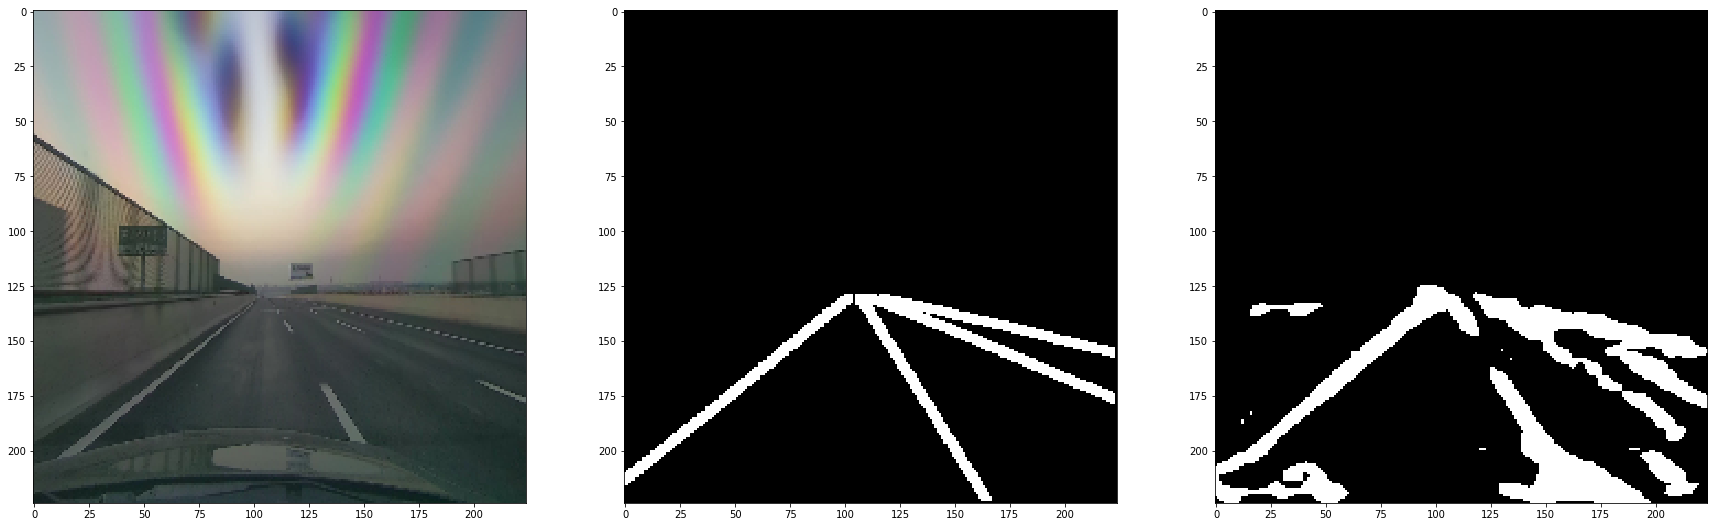

In [24]:
# show the detected points on a valid image
test_index = random.randint(0, len(val_labels))
test_label = val_labels[test_index,:,:,1]
test_img = plt.imread(val_image_paths[test_index])
test_img = cv2.resize(test_img,(DATA_SHAPE,DATA_SHAPE))
test_points = detect_points(test_img, model, DATA_SHAPE)
fig, axs = plt.subplots(1, 3, figsize=(30,30)) 
axs[0].imshow(test_img)
axs[1].imshow(test_label,cmap='gray')
axs[2].imshow(test_points,cmap='gray')
plt.show()

# Save result

In [24]:
# detect points for images set
def detect_test_list(model, shape):
    test_set_path = '/data/mc_data/MLDC/data/test0/images/' 
    test_md5_paths = open('/home/mc16/test0_list.txt','r').readlines()
    points_list = np.zeros((len(test_md5_paths), shape, shape), np.uint8)
    i = 0
    for path in tqdm(test_md5_paths):
        md5 = path.split('.')[0]
        img = plt.imread(test_set_path + md5 +'.jpg')
        points_logist = detect_points(img, model, shape)
        points_list[i] = points_logist
        i = i + 1
    return points_list

def detect_val_points(val_images, model, shape):
    points_list = np.zeros((len(val_images), shape, shape), np.uint8)
    i = 0
    for image in tqdm(val_images):
        points_list[i] = detect_points(image, model, shape)
        i = i + 1
    return points_list

In [34]:
# save detected points for images in test0 and val
import datetime
TIMEFORMAT = '%m-%d-%H:%M:%S'
time = datetime.datetime.now().strftime(TIMEFORMAT)
test_detect_points = detect_test_list(model, DATA_SHAPE)
np.save("/home/mc16/result/test_points_%s.npy"%time, test_detect_points)
time = datetime.datetime.now().strftime(TIMEFORMAT)
val_detect_points = detect_val_points(val_images, model, DATA_SHAPE)
np.save("/home/mc16/result/val_points_%s.npy"%time, val_detect_points)

100%|██████████| 2015/2015 [01:14<00:00, 27.03it/s]
